In [1]:
import pandas as pd

df = pd.read_csv("AmazonReview.csv")
print(df.shape)
df.head()



(25000, 2)


,Review,Sentiment
0,Fast shipping but this product is very cheaply...,1
1,This case takes so long to ship and it's not e...,1
2,Good for not droids. Not good for iPhones. You...,1
3,The cable was not compatible between my macboo...,1
4,The case is nice but did not have a glow light...,1


In [3]:
print(df.columns.tolist())





['Review', 'Sentiment']


In [4]:
df = df[['Review', 'Sentiment']]
df.dropna(inplace=True)
df.rename(columns={'Review': 'full_text', 'Sentiment': 'label'}, inplace=True)
df.head()


,full_text,label
0,Fast shipping but this product is very cheaply...,1
1,This case takes so long to ship and it's not e...,1
2,Good for not droids. Not good for iPhones. You...,1
3,The cable was not compatible between my macboo...,1
4,The case is nice but did not have a glow light...,1


In [5]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text.lower())
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

df['clean_text'] = df['full_text'].apply(preprocess)
df.head()



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


,full_text,label,clean_text
0,Fast shipping but this product is very cheaply...,1,fast shipping product cheaply made brought gra...
1,This case takes so long to ship and it's not e...,1,case take long ship even worth dont buy
2,Good for not droids. Not good for iPhones. You...,1,good droids good iphones cannot use feature wa...
3,The cable was not compatible between my macboo...,1,cable compatible macbook iphone also connector...
4,The case is nice but did not have a glow light...,1,case nice glow light disappointed product meet...


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['clean_text'])

y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.4676

Classification Report:
               precision    recall  f1-score   support

           1       0.56      0.61      0.58      1021
           2       0.36      0.35      0.36      1000
           3       0.38      0.36      0.37       985
           4       0.42      0.41      0.41       973
           5       0.59      0.60      0.59      1021

    accuracy                           0.47      5000
   macro avg       0.46      0.47      0.46      5000
weighted avg       0.46      0.47      0.47      5000


Confusion Matrix:
 [[623 254  85  34  25]
 [298 355 199  94  54]
 [117 235 351 196  86]
 [ 45  80 188 396 264]
 [ 38  51  96 223 613]]


In [9]:
print(df['label'].unique())



[1 2 3 4 5]


In [10]:
def convert_to_sentiment(rating):
    if rating in [1, 2]:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

df['sentiment'] = df['label'].apply(convert_to_sentiment)


In [11]:
positive_text = " ".join(df[df['sentiment'] == 'positive']['clean_text'])
negative_text = " ".join(df[df['sentiment'] == 'negative']['clean_text'])


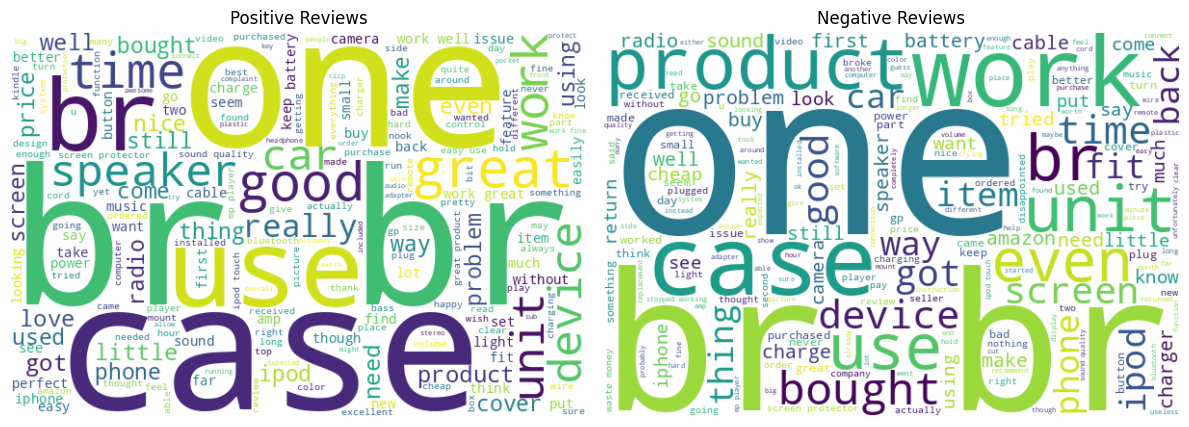

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

positive_text = " ".join(df[df['sentiment'] == 'positive']['clean_text'])
negative_text = " ".join(df[df['sentiment'] == 'negative']['clean_text'])

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
WordCloud(width=600, height=400, background_color='white').generate(positive_text)
plt.imshow(WordCloud(width=600, height=400, background_color='white').generate(positive_text), interpolation='bilinear')
plt.axis("off")
plt.title("Positive Reviews")

plt.subplot(1, 2, 2)
plt.imshow(WordCloud(width=600, height=400, background_color='white').generate(negative_text), interpolation='bilinear')
plt.axis("off")
plt.title("Negative Reviews")

plt.tight_layout()
plt.show()


In [13]:
import numpy as np

feature_names = vectorizer.get_feature_names_out()
coefs = model.coef_[0]

top_pos_indices = np.argsort(coefs)[-10:]
top_neg_indices = np.argsort(coefs)[:10]

print("Top Positive Terms:")
for i in reversed(top_pos_indices):
    print(f"{feature_names[i]}: {coefs[i]:.4f}")

print("\nTop Negative Terms:")
for i in top_neg_indices:
    print(f"{feature_names[i]}: {coefs[i]:.4f}")


Top Positive Terms:
waste: 4.0114
garbage: 3.3746
junk: 3.3095
worst: 3.0431
horrible: 2.9882
poor: 2.9833
terrible: 2.9119
disappointed: 2.8454
even: 2.7641
money: 2.6759

Top Negative Terms:
great: -5.6913
nice: -3.7680
well: -3.6835
good: -3.4320
love: -3.4265
easy: -3.3361
perfect: -2.8945
fine: -2.8236
ok: -2.7445
perfectly: -2.6414


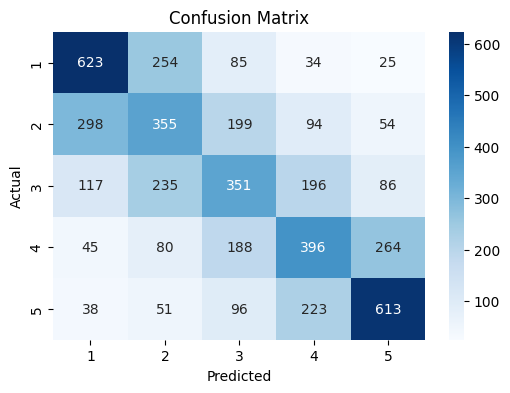

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
